In [7]:
# [CODE] Import modules
from IPython.display import clear_output
from pathlib import Path
import cmocean
import matplotlib.cm as cm
import cmcrameri
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from obspy.geodetics.base import gps2dist_azimuth,degrees2kilometers,locations2degrees
import pygmt
import pandas as pd
from scipy.interpolate import griddata
import matplotlib.colors as mcolors
from scipy.spatial import KDTree
from shapely.geometry import LineString, Point
from scipy.signal import detrend
import pygeodesy
from pygeodesy.ellipsoidalKarney import LatLon
import itertools
from collections.abc import Iterable
import matplotlib.image as mpimg
from scipy.interpolate import griddata
import os
import matplotlib.ticker as ticker
import netCDF4

# datafolder = Path('/Users/charlesh/Documents/Codes/OBS_Methods/NOISE/Research/Notebooks/632.Galapagos.GravData')
datafolder = Path('/Users/charlesh/Library/CloudStorage/GoogleDrive-choots@hawaii.edu/My Drive/_Papers/632_Paper')
plotfold = datafolder/'ProjFigs'
grdfolder = datafolder/'MapGrids'
gravdatafile = datafolder/'Processed_Daily_Grav'/'grv_all_sat.txt'
line_points = np.array([[-98, 2.249885], [-94,2.5],[-90.907174, 1.849262], [-90.707551, 0.921334], [-85.379041, 0.633260]])
egm_grid = grdfolder/'EGM2008_01m_global.grd'
egm_map = [egm_grid,[-12,12],'meters']

ginterpolator = pygeodesy.GeoidKarney(grdfolder/'egm2008-5.pgm')
geoid= lambda lat,lon: ginterpolator(LatLon(lat, lon))
wgs84 = lambda lat,a=6378.137,f=1/298.257222:a*((1+(((2*f)-(f**2))/((1-f)**2)) * (np.sin(np.deg2rad(lat)))**2  )**(-0.5))

In [8]:
# [CODE] Load Data

#figure size and # of contour lines. 
# I have alot of contours (levels) for paper quality figures and it slows this code a ton, so drop this number to go fast.
figsize=(10, 10);levels=20
column_names = ['Lon', 'Lat', 'Abolute_mGal', '4', 'FA_Anomaly_mGal', 'Bathymetry_meters', '7', '8']
data=pd.read_csv(gravdatafile,delim_whitespace=True,header=None,names=column_names)
df=data[['Lon', 'Lat', 'Abolute_mGal', 'FA_Anomaly_mGal','Bathymetry_meters']].copy()

df['Bathymetry_meters'] = df['Bathymetry_meters']
df = df[df['Bathymetry_meters']>=0]

mapgrids = datafolder/'MapGrids'
grd_file = mapgrids/'GEBCO_2024.grd'

WGM2012 = {'FreeAir':[mapgrids/'WGM2012'/'WGM2012_Freeair_ponc_2min.grd',[-40,40],  'WGM2012'+ r'$\Delta g_{FA}$ Free-Air, mGal'],
'GravDist':[mapgrids/'WGM2012'/'WGM2012_Disturbance_ponc_2min.grd',[-450,-200],     'WGM2012 Disturbance, mGal'],
'Isostatic':[mapgrids/'WGM2012'/'WGM2012_Isostatic_ponc_2min.grd',[-50, 50],        'WGM2012 \n'+ r'$\delta g_{I}$ Disturbance, mGal'],
'Bouguer':[mapgrids/'WGM2012'/'WGM2012_Bouguer_ponc_2min.grd',[-50,450],            'WGM2012' + r'$\Delta g_{CB}$'+'\n Complete Bouguer, mGal'],
'ETOPO':[mapgrids/'WGM2012'/'WGM2012_ETOPO1_ponc_2min.grd',[-4502,-1520],           'WGM2012 \n' +'WGM2012 ETOPO, m']}
bath_cmap=plt.cm.jet.resampled(20)

ds = netCDF4.Dataset(grd_file)
grid_data = pygmt.grd2xyz(grd_file, output_type="pandas");grid_data = grid_data[~grid_data.z.isna()]
df_hold = df.copy()

/var/folders/4c/3xb25hld3w73hv1lxgbg7r9m0000gn/T/ipykernel_35734/3916618723.py:7: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data=pd.read_csv(gravdatafile,delim_whitespace=True,header=None,names=column_names)


In [9]:
# [CODE] Support Functions
import numpy as np

def g0(latitude_deg):
    # Convert latitude to radians
    phi = np.radians(latitude_deg)
    # Constants for WGS84
    gamma_e = 9.7803253359  # gravity at equator in m/s^2
    k = 0.00193185265241    # Somigliana constant
    e2 = 0.00669437999013   # first eccentricity squared
    # Normal gravity equation
    gamma = gamma_e * (1 + k * np.sin(phi)**2) / np.sqrt(1 - e2 * np.sin(phi)**2)
    return gamma

def darken_colormap(cmap, factor=0.7):
    """Darkens a colormap by a given factor (0 < factor < 1)."""
    def darken_color(color):
        return tuple([c * factor for c in color[:3]] + [color[3]])  # Adjust RGB, keep alpha
    colors = [darken_color(cmap(i)) for i in range(cmap.N)]
    return mcolors.ListedColormap(colors, name=f"{cmap.name}_darkened")
def pygmt_cmap(cmap):
    # cmap='gmt/gebco'
    cpt_file = 'temp_cmap.cpt'
    pygmt.makecpt(cmap=cmap, series=[-7000, 0], output=cpt_file,color_model='r',continuous=True)
    cmap_data = pd.read_csv(cpt_file,delim_whitespace=True,header=None,names=['A','B','C','D','E'])
    os.remove(cpt_file)
    cmap_data=cmap_data.iloc[:-3]
    # rgb_array = cmap_data[:, :3] / 255.0
    cmap_data['B']=[[int(i)/255 for i in (j.split('/'))] for j in cmap_data.B]
    cmap_data['D']=[[int(i)/255 for i in (j.split('/'))] for j in cmap_data.D]
    A=cmap_data[['A','B']]
    B=cmap_data[['C','D']]
    B=B.rename(columns={'C':'A','D':'B'})
    cmap_data=pd.concat([A,B])
    cmap_data['A']=[float(i) for i in cmap_data.A.values]
    cmap_data=cmap_data.sort_values(by=['A'])
    cmap_data=cmap_data.iloc[np.unique(cmap_data.A,return_index=True)[1].tolist()]
    zmin, zmax = min(cmap_data.A), max(cmap_data.A)
    znorm = [(z - zmin) / (zmax - zmin) for z in cmap_data.A]
    from matplotlib.colors import LinearSegmentedColormap
    return LinearSegmentedColormap.from_list(name='test',colors=[(i,j[0],j[1],j[2]) for i,j in zip(cmap_data.A.values,np.array([i for i in cmap_data.B.values]).tolist())])
def unravel(nested_list):
    flat_list = []
    for item in nested_list:
        test=(isinstance(item, Iterable)) and (not isinstance(item, str))
        if test:flat_list.extend(unravel(item))
        else:flat_list.append(item)
    return flat_list
def ridge_distance(lola):
    line_points = np.array([[-98, 2.249885], [-94,2.5],[-90.907174, 1.849262], [-90.707551, 0.921334], [-85.379041, 0.633260]])
    line = LineString(line_points)
    point = Point(lola)
    closest_point_on_line = line.interpolate(line.project(point))
    shortest_distance, _, _ = gps2dist_azimuth(lola[1], lola[0], closest_point_on_line.y, closest_point_on_line.x)
    p=-1 if point.y>closest_point_on_line.y else 1
    # print(f"Closest point on the line: {closest_point_on_line}")
    # print(f"Shortest distance to the line: {shortest_distance:.2f} meters")
    return p*shortest_distance
wgs84 = lambda lat,a=6378.137,f=1/298.257222:a*((1+(((2*f)-(f**2))/((1-f)**2)) * (np.sin(np.deg2rad(lat)))**2  )**(-0.5))

def basemap():
    x_min, x_max = ds.variables["x_range"][:]
    y_min, y_max = ds.variables["y_range"][:]
    dx, dy = ds.variables["spacing"][:]
    nx, ny = ds.variables["dimension"][:]
    x = np.linspace(x_min, x_max - dx, nx)
    y = np.linspace(y_max - dy, y_min, ny)  # descending order
    z_flat = ds.variables["z"][:]
    z = z_flat.reshape((ny, nx))  # z is indexed [y, x]
    clim=np.array([np.min(z),np.max(z)])
    clim=np.array([-5000,1600])
    vmin,vmax=clim
    x_sub,y_sub,z_sub = x,y,z
    z_sub = np.ma.masked_where(z_sub > 1600, z_sub)
    z_sub = np.ma.masked_where(z_sub < -6000, z_sub)
    lon2d, lat2d = np.meshgrid(x_sub, y_sub)
    box=(lon2d<(df.Lon.min()-0.1))&(lon2d>(0.1+df.Lon.max()))&(lat2d<(df.Lat.min()-0.1))&(lat2d>(df.Lat.max()+0.1))
    lon2d= np.ma.masked_where(box,lon2d)
    lat2d=np.ma.masked_where(box,lat2d)
    z_sub=np.ma.masked_where(box,z_sub)
    return lon2d,lat2d,z_sub


def getmap(file):
    ds = netCDF4.Dataset(file)
    xvar='x' if not np.isin('lon',list(ds.variables.keys())) else 'lon'
    yvar='y' if not np.isin('lat',list(ds.variables.keys())) else 'lat'
    try:
        x_min, x_max = ds.variables[xvar][:]
        y_min, y_max = ds.variables[yvar][:]
        dx, dy = ds.variables["spacing"][:]
        nx, ny = ds.variables["dimension"][:]
        x = np.linspace(x_min, x_max - dx, nx)
        y = np.linspace(y_max - dy, y_min, ny)  # descending order
    except:
        x = ds.variables[xvar][:]
        y = ds.variables[yvar][:]
        nx,ny = x.shape[0],y.shape[0]
    z_flat = ds.variables["z"][:]
    z = z_flat.reshape((ny, nx))  # z is indexed [y, x]
    x_sub,y_sub,z_sub = x,y,z
    # Trim
    xbox = (x_sub>=(df.Lon.min()-0.1))&(x_sub<=(0.1+df.Lon.max()))
    ybox = (y_sub>=(df.Lat.min()-0.1))&(y_sub<=(0.1+df.Lat.max()))
    x_sub = x_sub[xbox];y_sub = y_sub[ybox];z_sub = z_sub[ybox,:][:,xbox]

    # Mask outlier values (to shave off the mountains in topo maps)
    z_sub = np.ma.masked_where(z_sub > 1600, z_sub)
    z_sub = np.ma.masked_where(z_sub < -6000, z_sub)


    # Mesh lat/lons
    xx, yy = np.meshgrid(x_sub, y_sub)
    zz = z_sub

    # box=(lon2d<(df.Lon.min()-0.1))&(lon2d>(0.1+df.Lon.max()))&(lat2d<(df.Lat.min()-0.1))&(lat2d>(df.Lat.max()+0.1))
    # lon2d= np.ma.masked_where(box,lon2d)
    # lat2d=np.ma.masked_where(box,lat2d)
    # z_sub=np.ma.masked_where(box,z_sub)
    return xx,yy,z_sub


def df_scatter(keys,colorkey='Geoid_Anomaly_meters',cmap=None,figsize=None):
    fontprops={'fontweight':'bold','fontsize':12}
    colorlabel = colorkey.replace('FA_Anomaly_mGal','Free Air Anomaly').replace('Bathymetry','Batymetry,m').replace('Geoid_Anomaly_meters','Geoid Height,m')
    nrows,ncols=int(np.ceil(len(keys)/2)),int(np.floor(len(keys)/2))
    ncols=2
    figsize = (7.5*ncols,3.5*nrows) if figsize==None else figsize
    fig,axes = plt.subplots(nrows,ncols,figsize=figsize)
    axes=axes.reshape(-1)
    labels={'Lon':'Longitude, °','Lat':'Latitude, °','mgal':'Free-air anomaly, mGal',
    'FA_Anomaly_mGal':'Free-air anomaly, mGal',
    'Path':'Survey Path distance, km','Geoid_Anomaly_meters':'Geoid Height, m',
    'Bathymetry_meters':'Bathymetry, m','EllipsoidHeight_meters':'Ellipsoid Height, m',
    'MohoDepth_Using_Geoid_meters':'Moho depth correction from the Geoid, meters',
    'MohoPerturb_Using_FA_meters':'Moho depth correction, meters',
    'MohoPerturb_Using_GD_meters':'Moho depth correction GD, meters',
    'GD_Anomaly_mGal':'GD Anomaly in mGal','FA_GD_Overestimate_pct':'FA anomaly overestimate %',
    'FA_GD_Overestimate_mgal':'FA Overestimation in mGal',
    'EllipsoidHeight_meters':'Ellipsoid & Geoid Radii, meters','GD_G_T_FA_mGal':'T'}
    colors=df[colorkey].values
    cmap=plt.cm.get_cmap(cmap)
    colors=cmap(colors)
    if cmap:cmap='rainbow' if ((len(colors[colors<0])>0)&(len(colors[colors>0])>0)) else 'turbo'
    for ax,(x,y) in zip(axes,keys):
        ylim=[-300,300] if y=='FA_GD_Overestimate_pct' else [None,None]
        xx,yy,i = df[x].values,df[y].values,np.argsort(df[x].values)
        xx,yy,c = xx[i],yy[i],colors[i]
        c=df[colorkey].values[i]
        if y=='EllipsoidHeight_meters':
            sc3=ax.scatter(xx,yy,s=10,c='red',cmap=cmap,edgecolor='red',label='Ellipsoid')
            # sc3=ax.scatter(xx,yy,s=.05,c=c,cmap=cmap,edgecolor=None)
            yy2 = df['Geoid_Anomaly_meters'].values[i]
            yy=yy2+yy
            sc3=ax.scatter(xx,yy,s=10,c='blue',cmap=cmap,edgecolor='blue',label='Geoid',linewidth=0.5)
            # sc3=ax.scatter(xx,yy,s=.05,c=c,cmap=cmap,edgecolor= None)
            ax.legend(fontsize=12,markerscale=4)
        else:
            sc3=ax.scatter(xx,yy,s=10,c=c,cmap=cmap,edgecolor='none')
            ax.axhline(0,linestyle=':',c='k')
        # sc3=ax.bar(df[x],df[y],color=colors,width=0.05)
        ax.set_xlabel(labels[x],**fontprops)
        ax.set_ylabel(labels[y],labelpad=-1,**fontprops)
        ax.axvline(xx[c==min(c[c>0])],linestyle=':')
        ax.grid(alpha=0.4)
        ax.set_ylim(ylim)
    cbar_ax = fig.add_axes([0.92, 0.10, 0.01, 0.7])
    scalar_map = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=np.min(df[colorkey].values[i]), vmax=np.max(df[colorkey].values[i])))
    scalar_map.set_array([])
    cbar=fig.colorbar(scalar_map, cax=cbar_ax, label=colorlabel,aspect=90,shrink=.3,location='right')
    cbar.ax.set_ylabel(labels[colorkey], fontweight='bold', fontsize=12)
    cbar.ax.tick_params(labelsize=11)
    for label in cbar.ax.get_yticklabels():label.set_fontweight('bold')
def df_map(key='FA_Anomaly_mGal',
    bath_cmap=cmocean.cm.topo,levels=20,
    xlim=[df.Lon.min(),df.Lon.max()],
    ylim=[df.Lat.min(),df.Lat.max()],
    figsize=(10, 10),mapgrid=None,map_clim=None,title=None,colorscatter=True):
    fig = plt.figure(figsize=figsize)
    custom_cmap=bath_cmap
    if True: #Bathymetry
        if mapgrid==None:
            lon2d,lat2d,z_sub = basemap()
            clim=np.array([np.min(z_sub),np.max(z_sub)])
            clim=np.array([-5000,1600])
            vmin,vmax=clim
            bath_norm = mcolors.TwoSlopeNorm(vmin=.6*vmin, vcenter=0, vmax=.3*vmax)
            map_units='Bathymetry, m'
        else:
            lon2d, lat2d, z_sub = getmap(mapgrid[0])
            clim=map_clim if (map_clim!=None) else np.array(mapgrid[1])
            vmin,vmax=clim
            # z_sub[z_sub>max(clim)]=max(clim)
            # z_sub[z_sub<min(clim)]=min(clim)
            map_units=mapgrid[2]
            if map_units.lower().find('mgal')>-1:
                xx,yy,zz = getmap(WGM2012['ETOPO'][0])

            if key=='SimpleBouguer_mGal':
                #  z_sub = np.ma.masked_where(zz > 0, z_sub)
                #  zz = np.ma.masked_where(zz > 0, zz)
                 clim = [0,450];vmin,vmax = clim
                 z_sub = z_sub - ((-0.1119e-5*abs(zz))/mGal_to_ms2)
                 map_units = map_units.replace('FA','SB').replace('Free','\n Simple').replace('Air','Bouguer')
            # bath_norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
            bath_norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
            # bath_norm = mcolors.Normalize(vmin=min(clim), vmax=max(clim),clip=True)

        # z_sub=z_sub[::3,::3];lon2d=lon2d[::3,::3];lat2d=lat2d[::3,::3]
        csf = plt.contourf(lon2d, lat2d, z_sub,levels=levels, linewidths=0.5,cmap=custom_cmap,vmin=vmin, vmax=vmax,norm=bath_norm)
        cs = plt.contour(lon2d, lat2d, z_sub, colors="black",levels=levels, linewidths=0.5,vmin=vmin, vmax=vmax)
    props=get_props(df,key)
    cmap=props['cmap'];clim_extended=props['clim_extended'];norm=props['norm'];title=props['title'] if title==None else title
    colorres=props['colorres'];clim=props['clim']
    plt.xlabel('Longitude');plt.ylabel('Latitude')
    scattersize = 10
    xx=df.Lon;yy=df.Lat;zz=df[key]
    # zz[zz>max(clim)]=max(clim)
    # zz[zz<min(clim)]=min(clim)
    if colorscatter:
        sc=plt.scatter(xx,yy,s=20,c='k',cmap=cmap,norm=norm,zorder=500)
        sc=plt.scatter(xx,yy,s=scattersize,c=zz,cmap=cmap,norm=norm,zorder=1000) #,edgecolors='k',linewidths=0.1
    else:
        sc = plt.scatter(xx,yy,c='k',s=.1,zorder=1e3)
    plt.title(title,fontweight='bold',fontsize=14)
    plt.xlim([xx.min(), xx.max()]);plt.ylim([yy.min(), yy.max()]);plt.grid('major',alpha=.2,c='k')



    relief_overlay = True
    if relief_overlay:
        clim=np.array([0,20])
        vmin,vmax=clim
        bath_norm_relief = mcolors.Normalize(vmin=vmin, vmax=.3*vmax)
        lon2d,lat2d,z_sub = basemap()
        plt.contour(lon2d, lat2d, z_sub,levels=1, linewidths=0.5,cmap=custom_cmap,vmin=vmin, vmax=vmax,norm=bath_norm_relief,alpha=1,zorder=1e6)


    # plt.scatter(df.Lon,df.Lat,s=0.05,c='k',alpha=0.3,zorder=50000)
    ax=plt.gca()
    ax.set_aspect('equal')
    if key.lower().find('mgal')>=0:units='mGal'
    elif key.lower().find('depth')>=0:units='Meters'
    elif key.lower().find('meters')>=0:units='Meters'
    elif key.lower().find('pct')>=0:units='%'
    else:units=''
    norm_cbar=mcolors.Normalize(vmin=clim_extended[0], vmax=clim_extended[1],clip=True)
    cbar_ax = fig.add_axes([0.91, 0.64, 0.01, 0.15])

    sm = cm.ScalarMappable(cmap=bath_cmap, norm=bath_norm);sm.set_array([])  # required dummy
    # cbar = plt.colorbar(sm,label=map_units,cax=cbar_ax,shrink=0.5,aspect=30,orientation='vertical',extend='both')
    cbar = plt.colorbar(sm,label=map_units,cax=cbar_ax,shrink=0.5,aspect=30,orientation='vertical')
    cbar.locator = ticker.MaxNLocator(nbins=5)
    cbar.update_ticks()
    cbar.ax.tick_params(labelsize=8, labelcolor="black", width=1.2)
    for label in cbar.ax.get_yticklabels():label.set_fontweight("bold")
    cbar.ax.set_ylabel(cbar.ax.get_ylabel(),fontweight='bold',fontsize=10)
    # sm = cm.ScalarMappable(cmap=cmap, norm=norm_cbar);sm.set_array([])  # required dummy
    if colorscatter:
        key_cbar = fig.add_axes([0.91, 0.32, 0.01, 0.3])
        keybar = plt.colorbar(sc,label=units,cax=key_cbar,shrink=0.5, aspect=30, orientation='vertical',norm=None,extend='both')
        keybar.locator = ticker.MaxNLocator(nbins=5)
        keybar.update_ticks()
        for label in keybar.ax.get_yticklabels():label.set_fontweight("bold")
        keybar.ax.set_ylabel(keybar.ax.get_ylabel(),fontweight='bold',fontsize=15)

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel(ax.get_xlabel(),fontweight='bold',fontsize=12);ax.set_ylabel(ax.get_ylabel(),fontweight='bold',fontsize=12)

    clear_output(wait=True)
def get_props(df,key,props={}):
    colorres=20
    # meters_cmap=cmocean.cm.phase.resampled(colorres)
    meters_cmap=plt.colormaps.get_cmap('jet').resampled(colorres).reversed()
    mgal_cmap=plt.colormaps.get_cmap('jet').resampled(colorres)
    # pct_cmap=cmocean.cm.balance.resampled(colorres)
    pct_cmap=plt.colormaps.get_cmap('coolwarm').resampled(colorres).reversed()
    top=r'Moho ($\Delta\rho=600 kg/m^{3}$) depth correction (m) using the ' 
    if key=='MohoDepth_Using_Geoid_meters':title=top+'Geoid'
    elif key=='MohoPerturb_Using_GD_meters':title=top+'Disturbance'
    elif key=='MohoPerturb_Using_FA_meters':title=top+'Free-Air anomaly'
    elif key=='GD_Anomaly_mGal':title='$\delta g_{G}$|Gravity Disturbance (mGal)'
    elif key=='FA_Anomaly_mGal':title='$\Delta g_{FA}$| Free-Air Anomaly (mGal)'
    elif key=='GD_G_T_FA_mGal':title='$\Delta g_{SB}$|  Simple Bouguer Anomaly (mGal)'
    elif key=='SimpleBouguer_mGal':title='$\Delta g_{SB}$|  Simple Bouguer Anomaly (mGal)'
    elif key=='CompleteBouguer_mGal':title='$\Delta g_{CB}$|  Complete Bouguer Anomaly (mGal)'
    elif key=='Geoid_Anomaly_meters':title='$h_{g}$| Geoid Anomaly height (m) above the ellipsoid'
    elif key=='FA_GD_Overestimate_mgal':title='Free Air Anomaly Overestimation, mGal \n' +r'$Residual,mGal=\Delta g_{FA}$-$\delta g_{G}$'
    elif key=='FA_GD_Overestimate_pct':title='Free Air Anomaly Overestimation \n' +r'$Residual,\%=100\frac{\Delta g_{FA}-\delta g_{G}}{\Delta g_{FA}}$'
    elif key=='MohoCorrection_meters':title='Moho Correction'
    else:title=key
    if key=='FA_Anomaly_mGal':clim=[-40,40];cmap=mgal_cmap
    elif key.lower()=='Bathymetry_meters':clim=[df[key].min(),df[key].max()];cmap=meters_cmap.reversed()
    elif key=='Geoid_Anomaly_meters':clim=[-12,12];cmap=meters_cmap
    elif key=='MohoDepth_Using_Geoid_meters':clim=[-150,150];cmap=meters_cmap
    elif key=='MohoPerturb_Using_GD_meters':clim=[-400,400];cmap=meters_cmap
    elif key=='MohoPerturb_Using_FA_meters':clim=[-1000,1000];cmap=meters_cmap
    elif key=='GD_Anomaly_mGal':clim=[-50,50];cmap=mgal_cmap
    elif key=='GD_G_T_FA_mGal':clim=np.array([-50,450]);cmap=mgal_cmap
    elif key=='SimpleBouguer_mGal':clim=np.sort(np.array([0,450]));cmap=mgal_cmap
    elif key=='CompleteBouguer_mGal':clim=np.array([0,450]);cmap=mgal_cmap
    elif key=='FA_GD_Overestimate_mgal':clim=[-3.7,3.7];cmap=mgal_cmap
    elif key=='FA_GD_Overestimate_pct':clim=100*np.array([-1,1]);cmap=pct_cmap
    elif key=='MohoCorrection_meters':clim=[-150,150];cmap=meters_cmap
    else:clim=[df[key].min(),df[key].max()];cmap=mgal_cmap
    clim_extended=clim
    binary_test = (df[key].min()<0) & (df[key].max()>0)
    if key=='GD_G_T_FA_mGal':binary_test=False
    if key=='SimpleBouguer_mGal':binary_test=False
    norm=mcolors.TwoSlopeNorm(vmin=clim_extended[0], vcenter=0, vmax=clim_extended[1]) if binary_test else mcolors.Normalize(vmin=clim_extended[0],vmax=clim_extended[1],clip=True)
    props['cmap']=cmap;props['clim']=clim;props['clim_extended']=clim_extended;props['norm']=norm;props['title']=title;props['colorres']=colorres
    return props
clear_output()

<img src="./NB_png_assets/1.png" alt="A" width="1500">
<!-- y[(y<150)&(y>1)] = abs(y[(y<150)&(y>1)])**1.21 #Outliers in the shallower water columnns -->

# 👨🏻‍🔬 I. Theory
____


<center><h1><i>The gravity disturbance is defined as the difference of two fields observed at the same point on the reference ellipsoid. It has been demonstrated that the gravity disturbances are more appropriate for geophysical purposes (e.g., Hackney and Featherstone, 2003). This is obviously very generic however.</center></h1></i>


<h2><i>Conceptually, if we take a free-air anomaly and correct for it's distance from the geoid, it will (hopefully) approximate a more Bouguer-like anomaly now referenced at the geoid — but without requiring any mass correction. This is done by using the geoid anomaly with the free-air gradient (0.3086) to estimate the gravity correction necessary for gravity at the ellipsoid (free-air) to instead measure gravity at the true vertical height above the geoid and not just above the ellipsoid.</i></h1>

# Go here to download all my code (this notebook + data): https://tinyurl.com/HootsGrav632

# 🧮 II. Equations
____

<img src="./NB_png_assets/2.png" alt="A" width="1500">


<h1><i>You'll see in the next few pages this may produce an (arguable) increase in sensitivity to shorter wavelength (higher wavenumber) at the shallow subsurface at areas where the ellipsoid is above the geoid (thereby reducing its observing radial distance) and decimating sensitivity to  the same scale features at positions the ellipsoid is below the geoid (thereby increasing its observing radial distance)</i></h1>

<center><h1><i>Additionally, we can approximate the correction term necessary for the FA anomaly's approximation of the Moho depth (Hi Nik) using the slab equation</i></h1></center>

In [10]:
# [CODE] Calculate the GD Anomaly and Perturbations to the depth of the Moho
# --------Base QC. NaNs in the raw grav text file
df = df_hold.copy()
df['Geoid_Anomaly_meters']=[geoid(a.Lat,a.Lon) for a in df.iloc]
df['EllipsoidHeight_meters']=[wgs84(a.Lat) for a in df.iloc]
df['RidgeDistance_km'] = [ridge_distance(lola)/1000 for lola in (np.array([df.Lon,df.Lat]).T)]
# Path length
dx=[0];dx.extend([degrees2kilometers(locations2degrees(s.Lat,s.Lon,e.Lat,e.Lon)) for s,e in zip(df.iloc[:-1].iloc,df.iloc[1:].iloc)])
# There is two rows that define where the grav-data is discontinuous, remove them. (turned off/on when first arriving from Quito?)
df['Path']=dx
# df = df[df.Path<2].copy()
df['Path'] = df.Path.cumsum()
#Clear bad values at top of file
df=df.iloc[9:-2] # Only the first 9 values in the free-air anomaly file are very odd or set to NaN, so let's remove them.
# --------

# ----------
# -----Some notes-----
# MohoDepth_Using_Geoid = (0.3086 * hg) / (2*pi*G*rho)
# FreeAirAnomaly = (gmeasured + g_tie) - g_eotvos - g_normal  #I have this in file
# DeltaGravityDisturbance = FreeAirAnomaly + 0.3086 * hg
# 2*pi*G = 4.193e-5
# hg = height above (positive) or below (negative) the geoid
# 
# Fourier approximation is redundant for this experiment. 
# Just make the gravity disturbance and use it to approximate crustal thicknesses along the profile using either the given free-air anomaly data
# or the gravity disturbance data.
# _____________
mGal_per_meter = 0.3086 # Standard for a 6371km spherical earth at 9.8m/s2 gravity acceleration.
mGal_to_ms2 = 1e-5 # m/s^2 / mGal 
df['GD_Anomaly_mGal'] = df.FA_Anomaly_mGal.values+df.Geoid_Anomaly_meters.values * mGal_per_meter



df['FA_GD_Overestimate_mgal']=(df['FA_Anomaly_mGal']-df['GD_Anomaly_mGal'])
df['FA_GD_Overestimate_pct']=100*(((df['FA_Anomaly_mGal']-df['GD_Anomaly_mGal']))/df['FA_Anomaly_mGal'])

# FA - (FA + Hg_mgal)

# df['FA-GD_Residual'] = ((df['FA_Anomaly_mGal']) - (df['GD_Anomaly_mGal'] ))
d_rho = 600 ; #Density change at the Moho
G = 6.674e-11 #Gravitational constant
pi2Grho = 2*np.pi*G*d_rho # Units of s^-2
df['mGal_Anomaly_Using_Geoid'] = df.Geoid_Anomaly_meters.values * mGal_per_meter #mGal
df['MohoDepth_Using_Geoid_meters'] = -((df['mGal_Anomaly_Using_Geoid']  * mGal_to_ms2) / pi2Grho)
df['MohoPerturb_Using_GD_meters'] = -(df.GD_Anomaly_mGal * mGal_to_ms2) / pi2Grho
df['MohoPerturb_Using_FA_meters'] = -(df.FA_Anomaly_mGal * mGal_to_ms2) / pi2Grho
df['MohoCorrection_meters'] = df.FA_GD_Overestimate_mgal * mGal_to_ms2/ pi2Grho

d_rho = 1670 ; #Density change at the seafloor
G = 6.674e-11 #Gravitational constant
pi2Grho = 2*np.pi*G*d_rho # Units of s^-2
df['dgT_SeafloorCorrection_mGal']= ((pi2Grho*(df.Bathymetry_meters)))/mGal_to_ms2


# 📈 III. Data
____

In [11]:
# [CODE] Dataframe Summary
df

Lon     Lat  Abolute_mGal  FA_Anomaly_mGal  Bathymetry_meters  \
34    -83.2022  8.2094      978167.0            -11.9            998.892   
35    -83.2069  8.2018      978169.7             -9.3           1063.569   
36    -83.2116  8.1941      978170.4             -8.1           1147.574   
37    -83.2162  8.1865      978168.6             -8.7           1225.673   
38    -83.2207  8.1789      978165.6            -11.5           1356.415   
...        ...     ...           ...              ...                ...   
10673 -90.6249 -1.2869      978042.3             45.7            603.785   
10674 -90.6206 -1.2831      978043.7             47.1            605.022   
10675 -90.6164 -1.2794      978044.5             47.8            510.561   
10676 -90.6121 -1.2758      978045.8             49.2             55.503   
10677 -90.6078 -1.2722      978046.4             51.0            318.926   

       Geoid_Anomaly_meters  EllipsoidHeight_meters  RidgeDistance_km  \
34                12.001170             6377.698822       -871.881758   
35                11.967966             6377.699628       -870.930227   
36                11.935013             6377.700443       -869.968152   
37                11.903396             6377.701247       -869.019841   
38                11.873142             6377.702050       -868.074663   
...                     ...                     ...               ...   
10673             -5.979106             6378.126159        243.329531   
10674             -5.916196             6378.126223        242.884283   
10675             -5.856122             6378.126285        242.450674   
10676             -5.797364             6378.126345        242.027509   
10677             -5.739991             6378.126405        241.604345   

              Path  GD_Anomaly_mGal  FA_GD_Overestimate_mgal  \
34        8.831069        -8.196439                -3.703561   
35        9.821890        -5.606686                -3.693314   
36       10.822217        -4.416855                -3.683145   
37       11.807347        -5.026612                -3.673388   
38       12.786871        -7.835948                -3.664052   
...            ...              ...                      ...   
10673  8223.440776        43.854848                 1.845152   
10674  8224.078774        45.274262                 1.825738   
10675  8224.701080        45.992801                 1.807199   
10676  8225.324574        47.410934                 1.789066   
10677  8225.948067        49.228639                 1.771361   

       FA_GD_Overestimate_pct  mGal_Anomaly_Using_Geoid  \
34                  31.122362                  3.703561   
35                  39.713057                  3.693314   
36                  45.470927                  3.683145   
37                  42.222851                  3.673388   
38                  31.861318                  3.664052   
...                       ...                       ...   
10673                4.037532                 -1.845152   
10674                3.876302                 -1.825738   
10675                3.780751                 -1.807199   
10676                3.636314                 -1.789066   
10677                3.473257                 -1.771361   

       MohoDepth_Using_Geoid_meters  MohoPerturb_Using_GD_meters  \
34                      -147.198097                   325.767596   
35                      -146.790836                   222.837815   
36                      -146.386661                   175.547970   
37                      -145.998869                   199.782773   
38                      -145.627790                   311.439897   
...                             ...                          ...   
10673                     73.335595                 -1743.011647   
10674                     72.563993                 -1799.426273   
10675                     71.827161                 -1827.984616   
10676                     71.106473                 -1884.34832

## 🌎 IV. The Geoid and Bathymetry
____

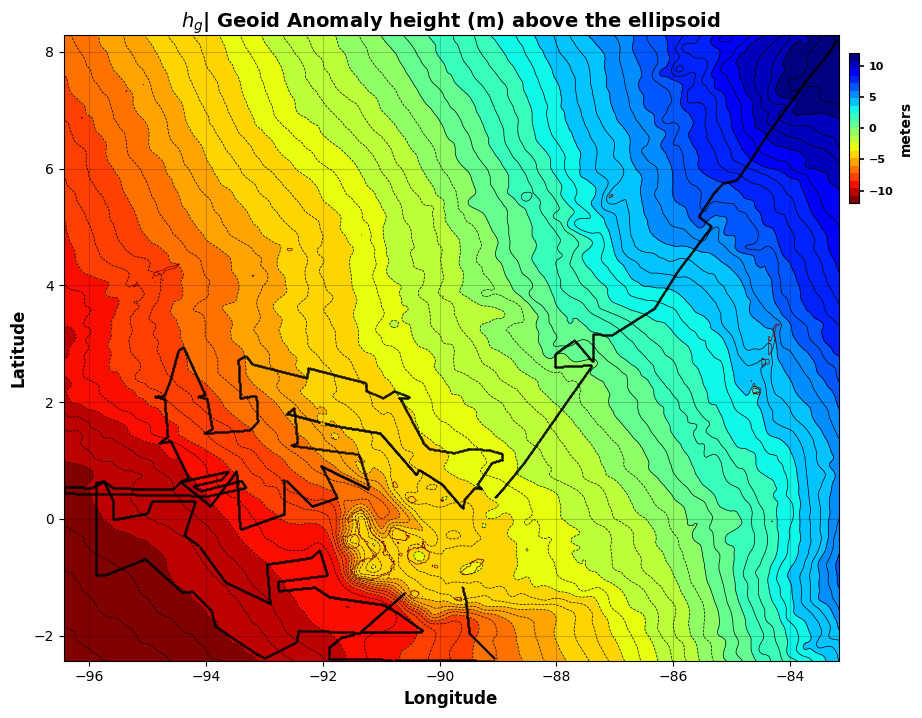

In [12]:
# [CODE][PLOT] Geoid Anomaly
# df_map('Geoid_Anomaly_meters',figsize=figsize,levels=levels,mapgrid=[egm_grid,[-12,12]])
# plt.savefig(plotfold/'GeoidAnomaly_meters.png',dpi=300,bbox_inches='tight')

df_map('Geoid_Anomaly_meters',figsize=figsize,levels=50,mapgrid=[egm_grid,[-12,12],'meters'],bath_cmap=plt.cm.jet.resampled(20).reversed(),colorscatter=False)
# plt.savefig(plotfold/'GeoidAnomaly_meters_onEGM2008.png',dpi=300,bbox_inches='tight')

# 🏔️ V. The Free-Air Anomaly (FA)
____

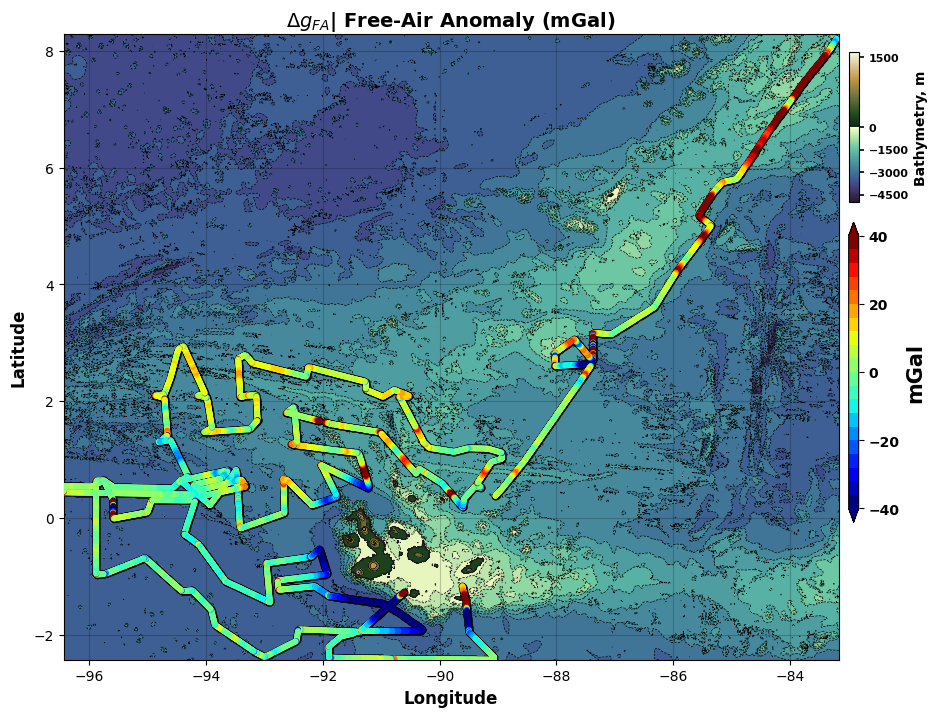

In [13]:
# [CODE][PLOT] Iguana Free-Air Anomaly
df_map('FA_Anomaly_mGal',figsize=figsize,levels=levels)
# plt.savefig(plotfold/'FreeAir_Anomaly_mGal.png',dpi=300,bbox_inches='tight')

# 💰 VI. The Expensive-Air Anomaly, Gravity Disturbance (GD) in mGal
____

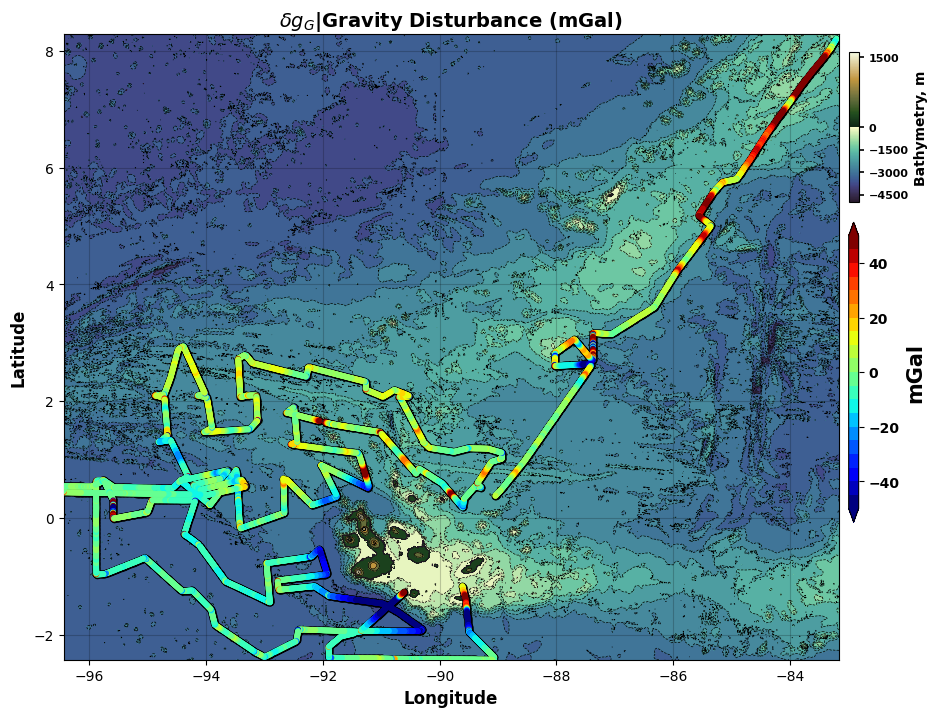

In [14]:
# [CODE][PLOT] Gravity Disturbance Anomaly in mGal
df_map('GD_Anomaly_mGal',figsize=figsize,levels=levels)
# plt.savefig(plotfold/'GravityDisturbance_Anomaly_mGal.png',dpi=300,bbox_inches='tight')

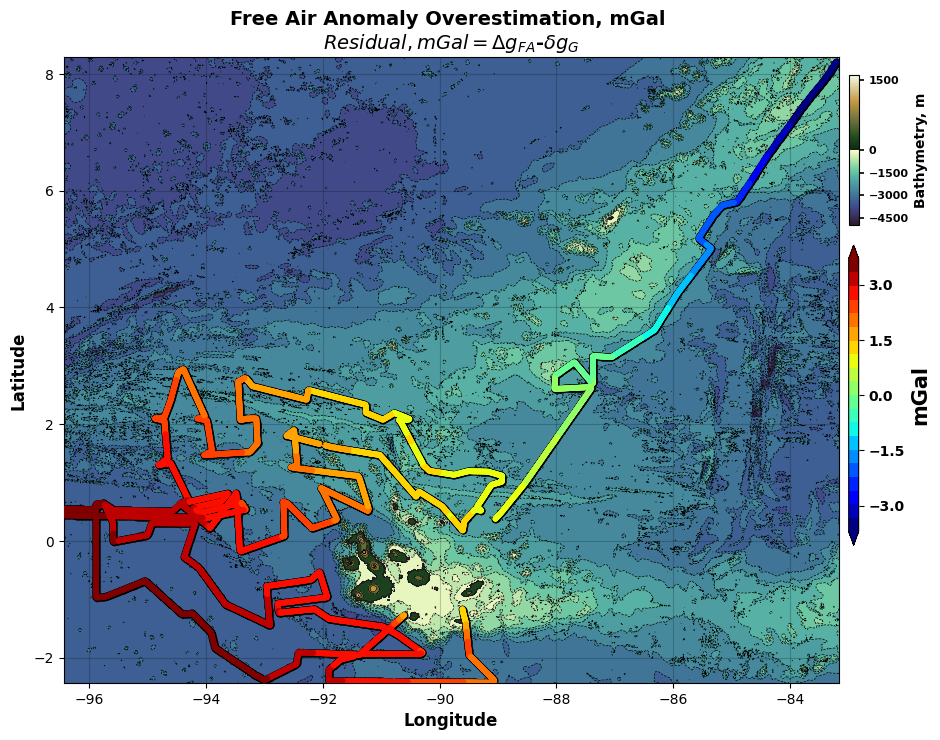

In [15]:
# [CODE][PLOT] FA-GD Residual in mGal and percent
df_map('FA_GD_Overestimate_mgal',figsize=figsize,levels=levels)
# plt.savefig(plotfold/'FA_GD_Resisual_mGal.png',dpi=300,bbox_inches='tight')

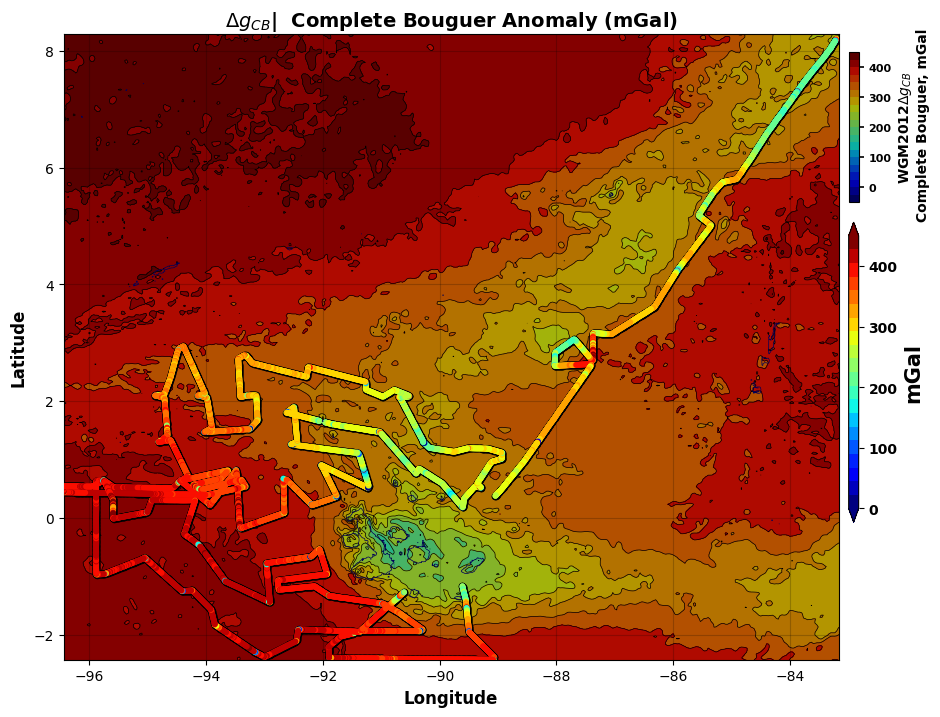

In [ ]:
#  Simple Bouguer Anomaly
y=(df['FA_Anomaly_mGal'] - ((-0.1119e-5*abs(df.Bathymetry_meters))/mGal_to_ms2)) #- TC
df['SimpleBouguer_mGal'] = y
bath_cmap=plt.cm.jet.resampled(20)
bath_cmap=darken_colormap(bath_cmap)
key='SimpleBouguer_mGal';
# mapgrid=WGM2012['Bouguer']
mapgrid=WGM2012['FreeAir']
df_map(key,levels=10,mapgrid=mapgrid,bath_cmap=bath_cmap)
plt.savefig(plotfold/'SimpleBouguer.png',dpi=300,bbox_inches='tight')


# Complete Bouguer Anomaly
TC = ((G*1670*((-df.Bathymetry_meters)**(1)))/mGal_to_ms2)
y=(df['FA_Anomaly_mGal'] - ((-0.1119e-5*abs(df.Bathymetry_meters))/mGal_to_ms2)) - TC
df['CompleteBouguer_mGal'] = abs(y)
bath_cmap=plt.cm.jet.resampled(20)
bath_cmap=darken_colormap(bath_cmap)
key='CompleteBouguer_mGal';mapgrid=WGM2012['Bouguer']
df_map(key,levels=10,mapgrid=mapgrid,bath_cmap=bath_cmap)
# plt.savefig(plotfold/'CompleteBouguer.png',dpi=300,bbox_inches='tight')

# VIII. Corrections to Crustal Thickness (Moho depth)

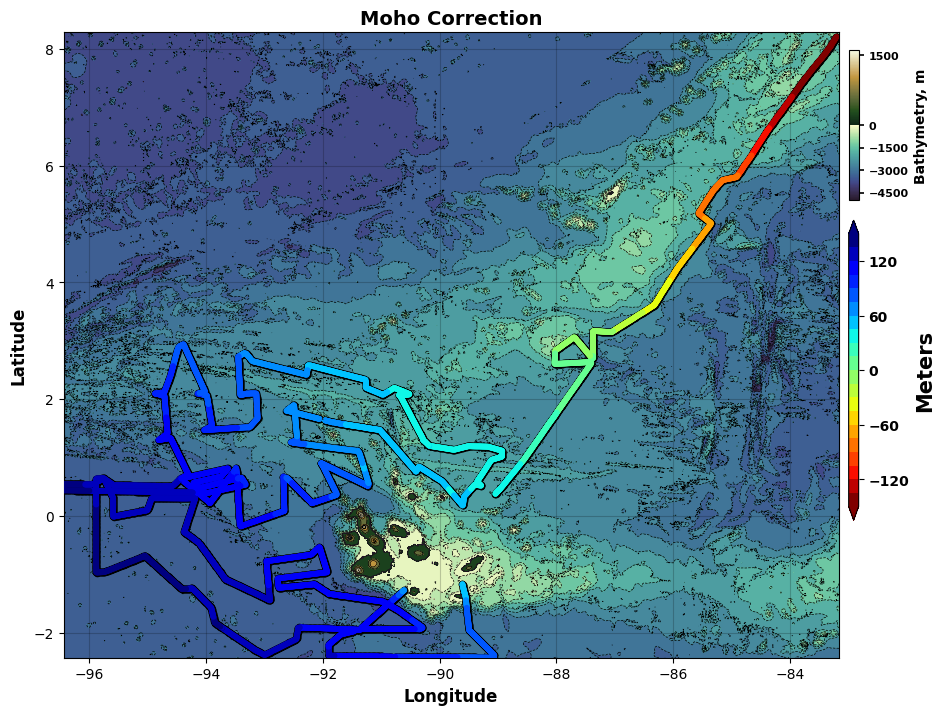

In [11]:
# [CODE][PLOT] Moho Correction in meters
df_map('MohoCorrection_meters',figsize=figsize,levels=levels)
# plt.savefig(plotfold/'MohoCorrection_meters.png',dpi=300,bbox_inches='tight')

/var/folders/4c/3xb25hld3w73hv1lxgbg7r9m0000gn/T/ipykernel_28986/292094035.py:142: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap=plt.cm.get_cmap(cmap)
/var/folders/4c/3xb25hld3w73hv1lxgbg7r9m0000gn/T/ipykernel_28986/292094035.py:151: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc3=ax.scatter(xx,yy,s=10,c='red',cmap=cmap,edgecolor='red',label='Ellipsoid')
/var/folders/4c/3xb25hld3w73hv1lxgbg7r9m0000gn/T/ipykernel_28986/292094035.py:155: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc3=ax.scatter(xx,yy,s=10,c='blue',cmap=cmap,edgecolor='blue',label='Geoid',linewidth=0.5)


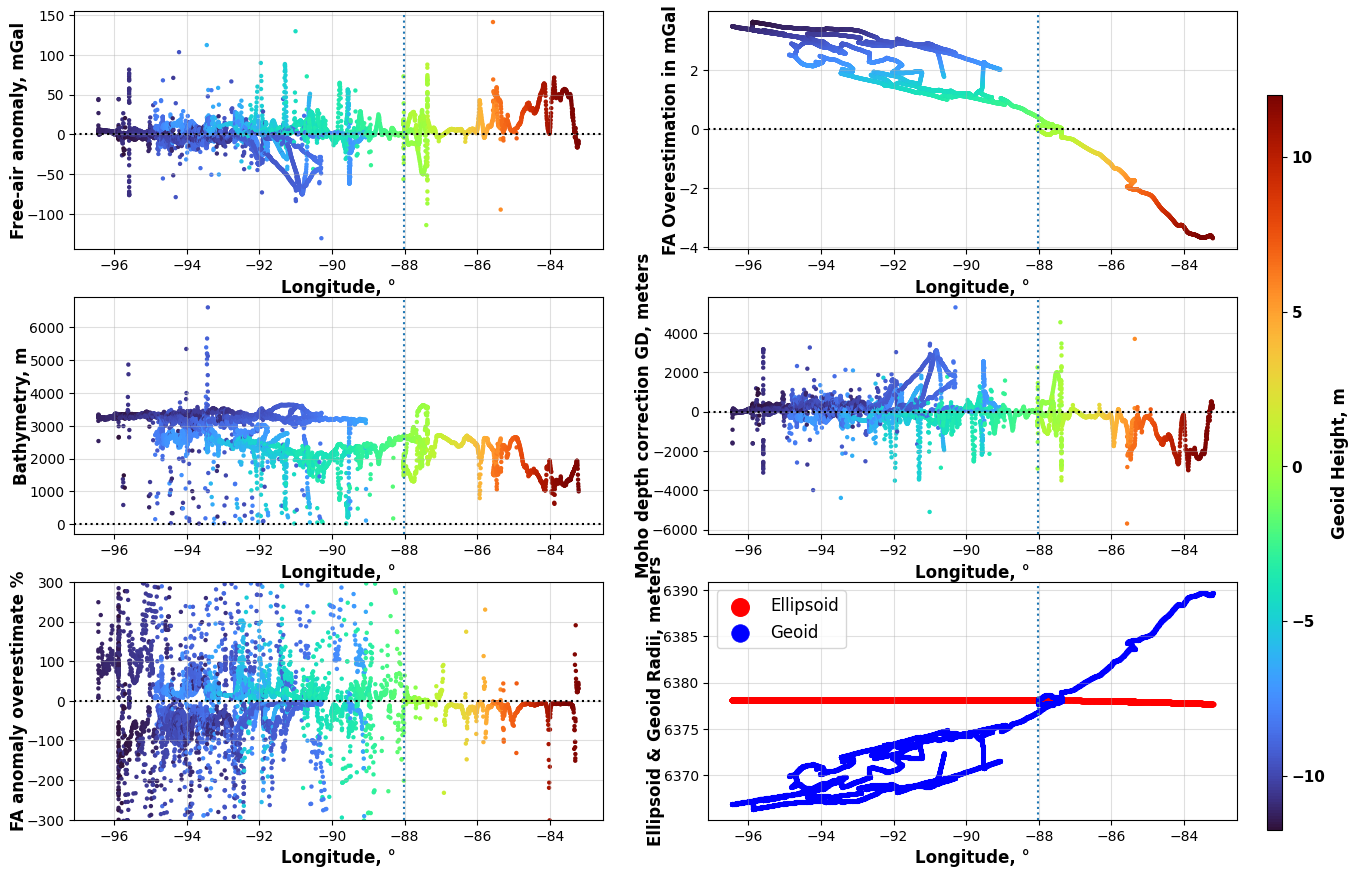

In [12]:
# [CODE][PLOT] Scatter plots vs Lon
x='Lon'
keys = [[x,'FA_Anomaly_mGal'],
[x,'FA_GD_Overestimate_mgal'],
[x,'Bathymetry_meters'],
[x,'MohoPerturb_Using_GD_meters'],
[x,'FA_GD_Overestimate_pct'],
[x,'EllipsoidHeight_meters']]
colorkey='Bathymetry_meters'
colorkey='Geoid_Anomaly_meters'
df_scatter(keys,cmap='rainbow',colorkey=colorkey)
plt.savefig(plotfold/'Scatters_vs_Lon.png',dpi=300,bbox_inches='tight')

/var/folders/4c/3xb25hld3w73hv1lxgbg7r9m0000gn/T/ipykernel_28986/292094035.py:142: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap=plt.cm.get_cmap(cmap)


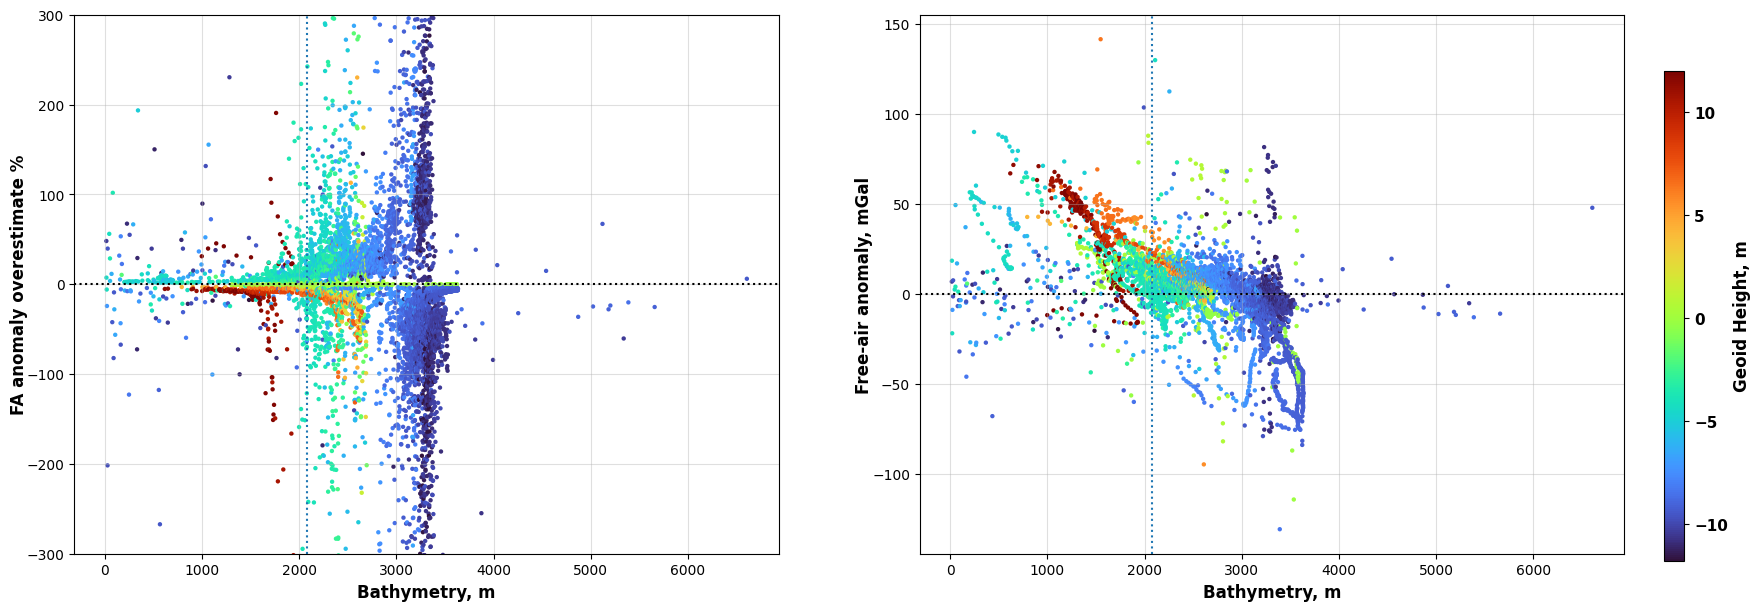

In [13]:
# [CODE][PLOT] Scatter Plot of FA-GD (in percent) vs Bathymetry (meters)
x='Bathymetry_meters'
keys = [[x,'FA_GD_Overestimate_pct'],[x,'FA_Anomaly_mGal']]
colorkey='Bathymetry_meters'
colorkey='Geoid_Anomaly_meters'
df_scatter(keys,cmap='rainbow',colorkey=colorkey,figsize=(20,7))
plt.savefig(plotfold/'Scatters_vs_Bath.png',dpi=300,bbox_inches='tight')

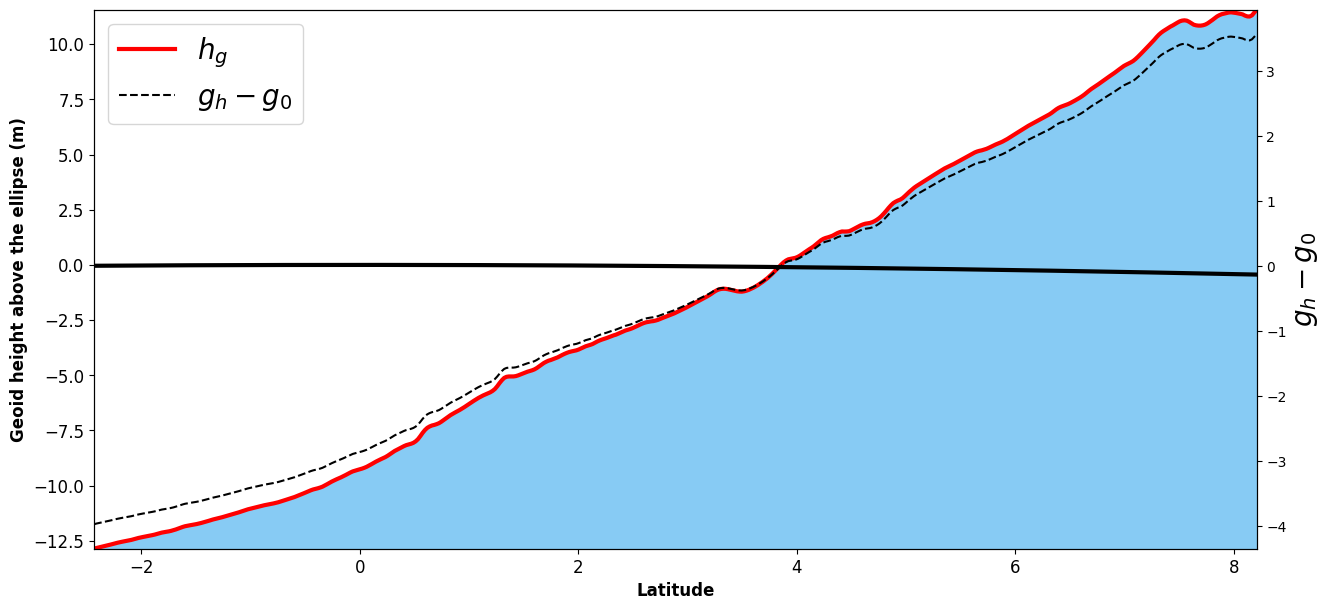

In [14]:
# [CODE][PLOT] Geoid Height vs Lon
plt.figure(figsize=(15, 7))
n = 500
la = [df.Lat.min(), df.Lat.max()]
lo = [df.Lon.min(), df.Lon.max()]
la = np.linspace(la[0], la[1], n)
lo = np.linspace(lo[0], lo[1], n)

line_wgs84 = np.array([wgs84(y) for y, x in zip(la, lo)])
line_geoid = np.array([geoid(y, x) for y, x in zip(la, lo)]) + line_wgs84
line_geoid = line_geoid - line_wgs84.max()
line_wgs84 = line_wgs84 - line_wgs84.max()
x = lo
xlabel = 'Longitude'
x = la; xlabel = 'Latitude'
plt.plot(x, line_geoid, c='r', linewidth=3,label=r'$h_{g}$')
color = 'blue'
color = cmcrameri.cm.bukavu.resampled(10)(2)
color = (135/255,203/255,244/255)
plt.fill_between(x, line_geoid, line_geoid * 0 + min(line_geoid),color=color)
plt.plot(x, line_wgs84, c='k', linewidth=3)
plt.xlim([x.min(), x.max()])
plt.ylim(line_geoid.min(), line_geoid.max())
ax = plt.gca()
fontprops = {'fontweight': 'bold', 'fontsize': 12}

# Remove set_yticklabels and set_xticklabels
# Use tick_params to style the ticks
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

# Ensure all ticks are displayed
ax.yaxis.set_major_locator(plt.MaxNLocator(prune=None))

plt.ylabel('Geoid height above the ellipse (m)', **fontprops)
plt.xlabel(xlabel, **fontprops)

# [geoid(ix,iy) for ix,iy in (lo,la)]

normalg = g0(x)/mGal_to_ms2
geog = (line_geoid*mGal_per_meter+(normalg))
res = geog-normalg

ax1 = plt.gca()
ax2 = ax1.twinx()
b = ax2.plot(x, res, 'k--',label='$g_{h} - g_{0}$')
ax2.set_ylabel(r'$g_{h} - g_{0}$', color='k',fontsize=20,fontweight='bold')
# ax2.tick_params(axis='y', labelcolor='k')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, fontsize=20, loc='upper left')  # Adjust fontsize and location
plt.savefig(plotfold/'GeoidHgtVsLon.png',dpi=600)


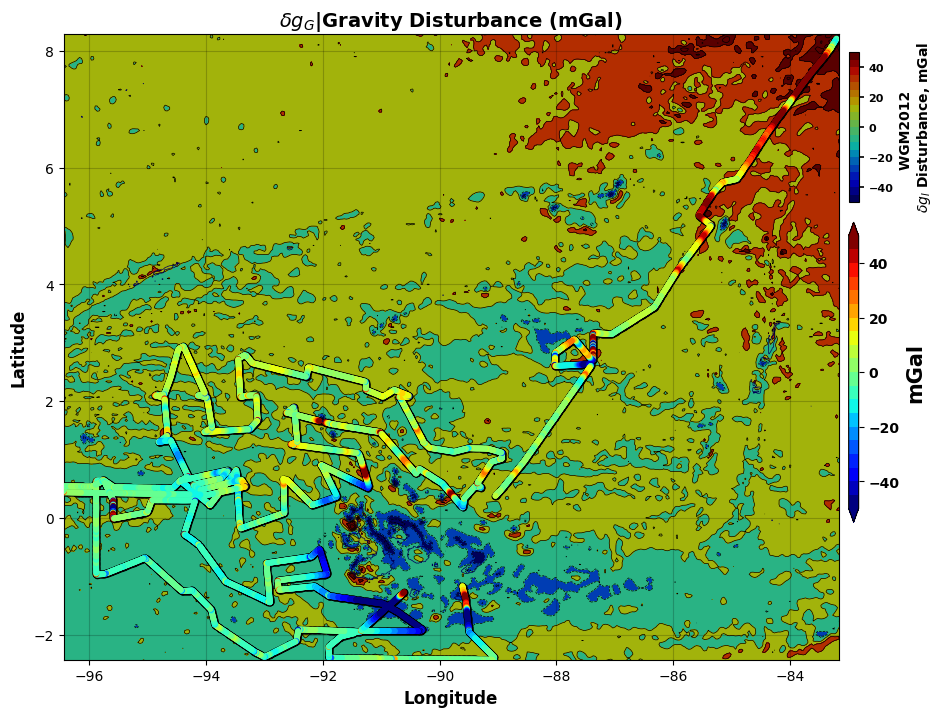

In [15]:
# [CODE][PLOT] GD vs dGI Map
bath_cmap=plt.cm.jet.resampled(20)
bath_cmap=darken_colormap(bath_cmap)
# mapgrid=WGM2012['FreeAir']
key='GD_Anomaly_mGal';mapgrid=WGM2012['Isostatic']
df_map(key,levels=10,mapgrid=mapgrid,bath_cmap=bath_cmap)
plt.savefig(plotfold/'GD_Anomaly_mGal_and_WGM2012_dgI.png',dpi=300,bbox_inches='tight')